In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
from vqls import *
from utils import *

label = 'sigmoid'
nq = 3
n_step = 8
file_path = f"results_{label}_{nq}.json"

In [2]:
df = pd.read_json(file_path)
df.head()

,Condition number,norm(yk),training_cost,exe_time,in_train_weights,RSS_q,RSS_h,seed
0,62.475139,1.77257,"[0.336020521, 0.4953441324, 0.2756440702000000...",6662.452654,"[[1.3697183816, 0.0814496594, 1.72681560249999...",3.963544,3.906801,2
1,62.475139,1.77257,"[0.483637554, 0.39265217900000005, 0.355513693...",10869.380081,"[[1.3374432558, 2.5590902949, 2.3103187244, 2....",9.433116,8.189226,27
2,62.475139,1.77257,"[0.3558372138, 0.3718882435, 0.4254641061, 0.4...",7009.160194,"[[2.9137660465, 2.7408080373, 1.83667331100000...",9.426826,8.211979,70
3,62.475139,1.77257,"[0.3290870047, 0.4689481441, 0.379511683000000...",20310.368043,"[[2.5858773995, 0.08205205900000001, 0.6621554...",0.276599,0.472436,52
4,62.475139,1.77257,"[0.3901495587, 0.3130892245, 0.296261129, 0.23...",17150.854078,"[[0.6548980927, 1.513245685, 1.3211592023, 2.6...",4.145746,4.071009,22


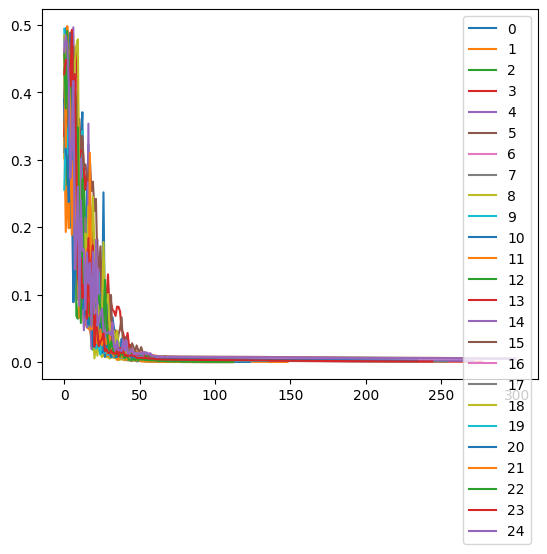

In [3]:
#Visualize training cost and obtain best performing epoch
argM = []
for i,item in enumerate(df["training_cost"].values):
    argM.append(np.argmin(item))
    plt.plot(item, label = i)
plt.legend()

In [4]:
## experimental specific settings


In [5]:

func_out = {'sigmoid': sigmoid_t,'tanh': tanh_t,'elu': elu_t, 'relu': relu_t, 'sin':sin_m}
func = func_out[label]


#############################################################################################
###################################### System Preparatio and _sin_#################
#############################################################################################

lower = 0. 
upper = 1. 
f_i = 0.0 
scaled=True
x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
y = [func(value,f_i) for value in x]

if scaled:
    norm = np.linalg.norm(y)
    y = y / norm

tck=splrep(x,y,k=1) #coeffs
matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled)


#############################################################################################
################################# VQLS and Linear Prob. Solving #############################
#############################################################################################


k_numb=np.linalg.cond(np.array(matrix))

vqls_circuit = VQLS(matrix,v_norm,nq,opt='COBYLA') 


beta_classic                 : [ 0.01014697  0.04047179 -0.02834388  0.37219079 -0.02117181  0.64683422
  0.41054771  0.55400577]


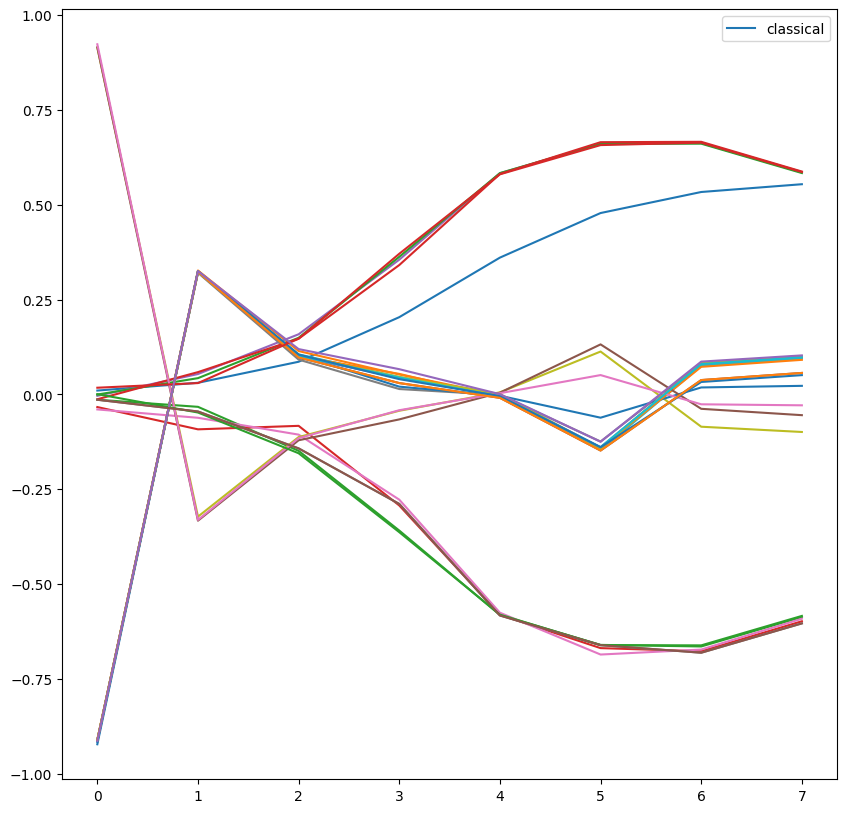

In [6]:
c = np.linalg.solve(matrix,vector)
print('beta_classic                 :',c)
plt.figure(figsize=(10,10))

y_c=np.dot(matrix,c) #classic
plt.plot(range(len(y_c)),y_c, label="classical")

for i,item in enumerate(df['in_train_weights']):
  weights = item[argM[i]]
  q = vqls_circuit.solution(weights).real
  y_q=np.dot(matrix,q) #hybrid
                        #Quantum

  y_fq=[]
  for el in matrix:
    y_fq.append(vqls_circuit.direct_prod2(weights,el))

  #plt.plot(range(len(y_fq)),y_q,label= f"h {i}")
  plt.plot(range(len(y_fq)),y_fq, )#label= f"fq {i}")
plt.legend()

In [7]:
best = np.argmin(df['RSS_q'])
weights = df['in_train_weights'][best][argM[best]]


In [8]:
print()


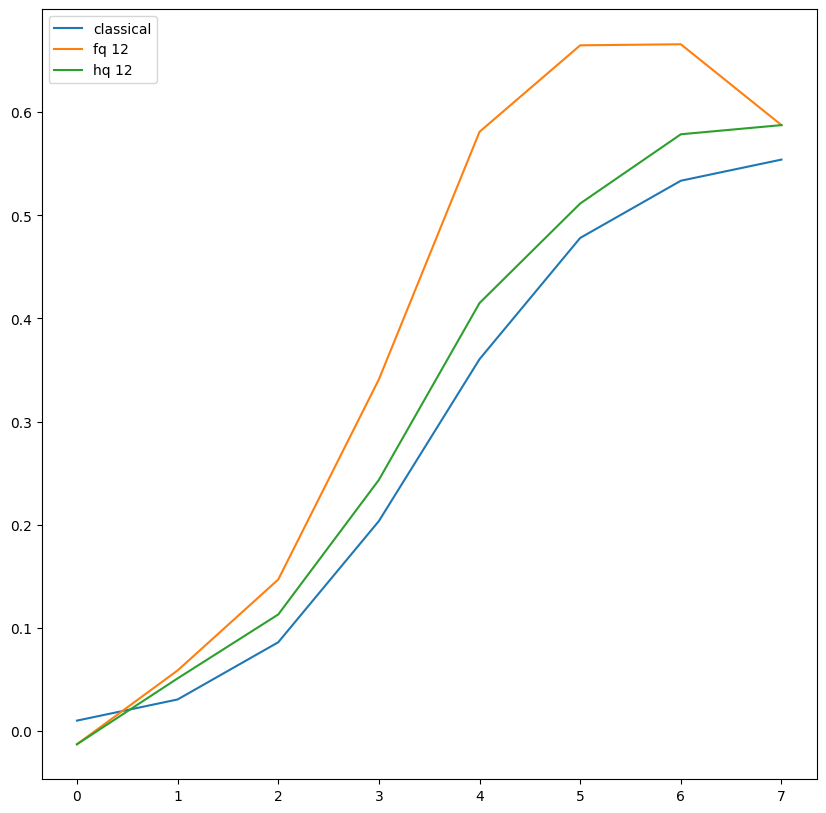

In [9]:
#Best performing model based on RSS
best = np.argmin(df['RSS_q'])
#best = 0

weights = df['in_train_weights'][best][argM[best]]
q = vqls_circuit.solution(weights).real
y_q=np.dot(matrix,q) #hybrid
                  #Quantum
plt.figure(figsize=(10,10))
plt.plot(range(len(y_c)),y_c, label="classical")

y_fq=[]
for el in matrix:
  y_fq.append(vqls_circuit.direct_prod2(weights,el))

#plt.plot(range(len(y_fq)),y_q,label= f"h {i}")
#plt.plot(range(len(y_fq)),np.abs(y_fq), label= f"fq abs {best}")
#plt.plot(range(len(y_fq)),np.abs(y_q), label= f"hq abs {best}")
plt.plot(range(len(y_fq)),(y_fq), label= f"fq {best}")
plt.plot(range(len(y_fq)),(y_q), label= f"hq {best}")
plt.legend()
#plt.savefig(f'{file_path[:-5]}.png')
plt.show()